In [1]:
from src.utils import *
import pandas as pd
from Bio.PDB import MMCIFParser
import numpy as np

#HTRA3 from uniprot
HTRA3="MQARALLLAALAALALAREPPAAPCPARCDVSRCPSPRCPGGYVPDLCNCCLVCAASEGEPCGGPLDSPCGESLECVRGLCRCRWSHAVCGTDGHTYANVCALQAASRRALQLSGTPVRQLQKGACPLGLHQLSSPRYKFNFIADVVEKIAPAVVHIELFLRHPLFGRNVPLSSGSGFIMSEAGLIITNAHVVSSNSAAPGRQQLKVQLQNGDSYEATIKDIDKKSDIATIKIHPKKKLPVLLLGHSADLRPGEFVVAIGSPFALQNTVTTGIVSTAQREGRELGLRDSDMDYIQTDAIINYGNSGGPLVNLDGEVIGINTLKVTAGISFAIPSDRITRFLTEFQDKQIKDWKKRFIGIRMRTITPSLVDELKASNPDFPEVSSGIYVQEVAPNSPSQRGGIQDGDIIVKVNGRPLVDSSELQEAVLTESPLLLEVRRGNDDLLFSIAPEVVM"
db=pd.read_csv("./data/HTRA3_peptides.csv")

db

/home/ubuntu/anaconda3/envs/char2024/lib/python3.8/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


,Unnamed: 0,Peptide_Experimental,IC50_uM,New_Delta_G_kcal/mol_Experimental
0,0,FGRWV,0.6,-7.5
1,1,RSWWV,0.6,-7.4
2,2,FGAWV,0.9,-7.7
3,3,FGRWI,1.0,-7.5
4,4,FARWV,1.1,-6.4
5,5,FGRWL,2.9,-6.6
6,6,FGRWA,3.5,-7.1
7,7,FGRWF,7.7,-7.3
8,8,FGRAV,270.0,-6.9


### Identify Reference peptide

In [2]:
db['ESM2_initialLoss'] = db['Peptide_Experimental'].apply(lambda peptide: compute_mlm_overall_withoutTheMaskedPos(HTRA3, peptide, [], []))
# db['ESM2_initialLoss'] = db['Peptide_Experimental'].apply(lambda peptide: compute_mlm_overall(HTRA1, peptide, [], []))
db

,Unnamed: 0,Peptide_Experimental,IC50_uM,New_Delta_G_kcal/mol_Experimental,ESM2_initialLoss
0,0,FGRWV,0.6,-7.5,13.592473
1,1,RSWWV,0.6,-7.4,13.562987
2,2,FGAWV,0.9,-7.7,13.613234
3,3,FGRWI,1.0,-7.5,13.574132
4,4,FARWV,1.1,-6.4,13.564548
5,5,FGRWL,2.9,-6.6,13.580356
6,6,FGRWA,3.5,-7.1,13.607949
7,7,FGRWF,7.7,-7.3,13.568269
8,8,FGRAV,270.0,-6.9,13.645667


In [3]:
min_index = db['ESM2_initialLoss'].idxmin()
reference_peptide = db.loc[min_index, 'Peptide_Experimental']
reference_peptide

'RSWWV'

### Get the binding affinity 

In [5]:
def compute_results(row):
    peptide = row['Peptide_Experimental']
    HTRA_positions = [] 
    pep_positions = np.array(find_differences(reference_peptide, peptide)) 
    print(reference_peptide, peptide, pep_positions)
    # return compute_mlm_overall(HTRA1, reference_peptide, HTRA_positions, pep_positions)
    return compute_mlm_overall_withoutTheMaskedPos(HTRA3, reference_peptide, HTRA_positions, pep_positions)

db['ESM2_ppi_score_overall'] = db.apply(compute_results, axis=1)
db

RSWWV FGRWV [0 1 2]
RSWWV RSWWV []
RSWWV FGAWV [0 1 2]
RSWWV FGRWI [0 1 2 4]
RSWWV FARWV [0 1 2]
RSWWV FGRWL [0 1 2 4]
RSWWV FGRWA [0 1 2 4]
RSWWV FGRWF [0 1 2 4]
RSWWV FGRAV [0 1 2 3]


,Unnamed: 0,Peptide_Experimental,IC50_uM,New_Delta_G_kcal/mol_Experimental,ESM2_initialLoss,ESM2_ppi_score_overall
0,0,FGRWV,0.6,-7.5,13.592473,13.593760
1,1,RSWWV,0.6,-7.4,13.562987,13.562987
2,2,FGAWV,0.9,-7.7,13.613234,13.593760
3,3,FGRWI,1.0,-7.5,13.574132,13.605514
4,4,FARWV,1.1,-6.4,13.564548,13.593760
5,5,FGRWL,2.9,-6.6,13.580356,13.605514
6,6,FGRWA,3.5,-7.1,13.607949,13.605514
7,7,FGRWF,7.7,-7.3,13.568269,13.605514
8,8,FGRAV,270.0,-6.9,13.645667,13.642647


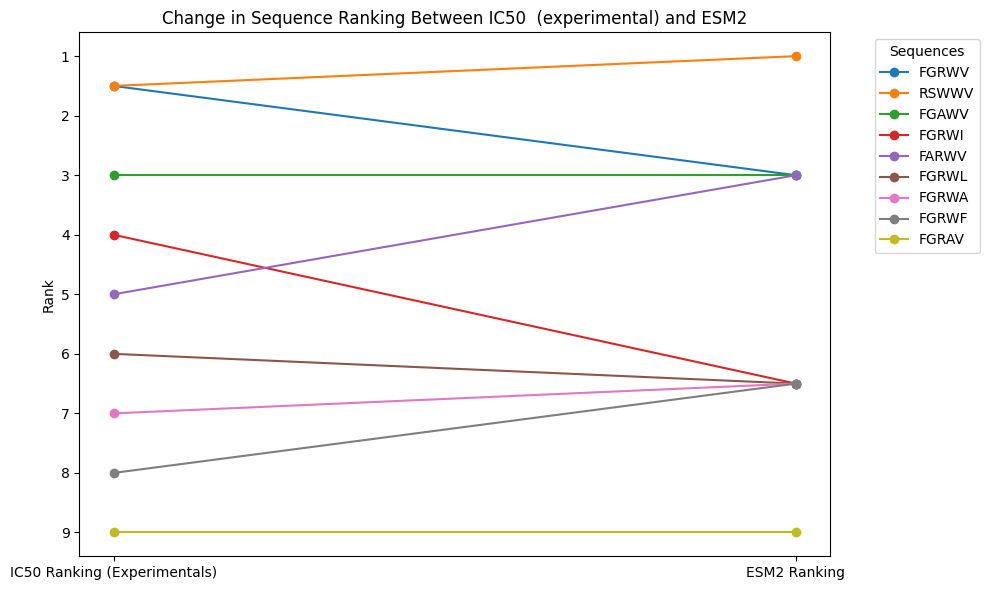

In [6]:
db['ESM2_Rank'] = db['ESM2_ppi_score_overall'].rank(ascending=True) 
db['IC50_Rank'] = db['IC50_uM'].rank(ascending=True) 


plt.figure(figsize=(10, 6))
for _, row in db.iterrows():
    plt.plot([1, 2], [row['IC50_Rank'], row['ESM2_Rank']], '-o', label=row['Peptide_Experimental'])

plt.xticks([1, 2], ['IC50 Ranking (Experimentals)', 'ESM2 Ranking'])
plt.gca().invert_yaxis()  # Invert y-axis so that lower ranks appear higher
plt.ylabel('Rank')
plt.title('Change in Sequence Ranking Between IC50  (experimental) and ESM2')
plt.legend(title="Sequences", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [7]:
from sklearn.metrics import ndcg_score
print("IC50",db["IC50_Rank"].values)
print("ESM2",db['ESM2_ppi_score_overall'].values)
ndcg_score([db["IC50_Rank"].values], [db["ESM2_ppi_score_overall"].values])

IC50 [1.5 1.5 3.  4.  5.  6.  7.  8.  9. ]
ESM2 [13.59375954 13.56298733 13.59375954 13.60551357 13.59375954 13.60551357
 13.60551357 13.60551357 13.64264679]


0.9762583907456084

In [8]:
ndcg_score([db["IC50_uM"].values], [db["ESM2_ppi_score_overall"].values])

0.9967716463315809

In [9]:
from scipy.stats import kendalltau
print(db['IC50_Rank'].values.astype(int))
print(db['ESM2_Rank'].values.astype(int))
# Calculate Kendall's Tau
tau, p_value = kendalltau(db['IC50_Rank'].values.astype(int), db['ESM2_Rank'].values.astype(int))

print(f"Kendall's Tau: {tau:.2f}")
print(f"P-value: {p_value:.4f}")

[1 1 3 4 5 6 7 8 9]
[3 1 3 6 3 6 6 6 9]
Kendall's Tau: 0.78
P-value: 0.0069
